# EDA & Anomaly Detection Test - Isolation Forest

In [1]:
from datetime import timedelta

# Config
STATE = 42 # Used for consistency during development, should be removed when performing actual anomaly detection.
SERVICE = 'ServiceA' 
LAMBDA = 'LambdaA'

USE_DURATION = False
METRIC = 'Duration' if USE_DURATION else 'ConcurrentExecutions' # Should be 'Duration' or 'ConcurrentExecutions'
METRIC_SLICE = None
# METRIC_SLICE = [5000, 8000] # Optional array for using only a slice of the whole metric e.g. [5000, 8000] will use df[5000:8000] later on

STL_DECOMP_PERIOD=288 # (Required) Period for stl decomposition. See https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html.
ANOMALY_NEIGHBOR_LIMIT = 2 # (Optional, int) Minimum number of anomalies in a row. Anomalies under this number are removed. 
POST_RELEASE_TRESHOLD = timedelta(days=1) # (Optional, timedelta) If defined, all anomalies after a release date within the treshold will be summed up and marked in the final graph.

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import util
import json
from sklearn.ensemble import IsolationForest

matplotlib.interactive('True')

# Metric conversion from exported CloudWatch JSON to pandas DataFrames
metrics = util.json_to_pandas(f'../ExportedMetrics/{SERVICE}/{LAMBDA}.json')
for metric in metrics:
    print(f'{metric.upper()}:\n',metrics[metric], '\n\n')

DURATION:
                      Timestamps      Values
0     2020-10-17 11:40:00+00:00  378.087143
1     2020-10-17 11:45:00+00:00  337.360294
2     2020-10-17 11:50:00+00:00  350.329167
3     2020-10-17 11:55:00+00:00  380.851136
4     2020-10-17 12:00:00+00:00  358.283182
...                         ...         ...
17931 2020-12-19 10:07:00+00:00  435.340213
17932 2020-12-19 10:12:00+00:00  386.125432
17933 2020-12-19 10:17:00+00:00  436.342903
17934 2020-12-19 10:22:00+00:00  464.948276
17935 2020-12-19 10:27:00+00:00  429.102174

[17936 rows x 2 columns] 


CONCURRENTEXECUTIONS:
                      Timestamps    Values
0     2020-10-17 11:40:00+00:00  2.047619
1     2020-10-17 11:45:00+00:00  1.617647
2     2020-10-17 11:50:00+00:00  1.250000
3     2020-10-17 11:55:00+00:00  1.613636
4     2020-10-17 12:00:00+00:00  1.954545
...                         ...       ...
17931 2020-12-19 10:07:00+00:00  1.425532
17932 2020-12-19 10:12:00+00:00  1.234568
17933 2020-12-19 10:17:00+00:00

### Importing microservice release dates

In [3]:
releases = util.load_releases('../ExportedMetrics/releases.json')
releases.head(10)

,ServiceNames,Timestamps
0,ServiceA,2020-10-15 13:09:02.003799915+00:00
1,ServiceHIK,2020-10-15 14:18:49.004899979+00:00
2,ServiceB,2020-10-15 14:21:56.005199909+00:00
3,ServiceB,2020-10-19 08:30:09.000400066+00:00
4,ServiceHIK,2020-10-21 13:49:47.005199909+00:00
5,ServiceB,2020-10-22 12:20:14.000600100+00:00
6,ServiceCD,2020-10-23 14:04:43.000400066+00:00
7,ServiceB,2020-10-28 09:16:09.000900030+00:00
8,ServiceB,2020-10-28 11:33:24.003599882+00:00
9,ServiceA,2020-10-29 09:56:09.004199982+00:00


In [4]:
# Some microservices are grouped together during release
release_service_map = {
    'ServiceA': 'ServiceA',
    'ServiceB': 'ServiceB',
    'ServiceC': 'ServiceCD',
    'ServiceD': 'ServiceCD',
    'ServiceE': 'ServiceEF',
    'ServiceF': 'ServiceEF',
    'ServiceH': 'ServiceHIK',
    'ServiceI': 'ServiceHIK',
    'ServiceJ': 'ServiceJ',
    'ServiceK': 'ServiceHIK'
}

service_releases = releases.loc[releases['ServiceNames'] == release_service_map[SERVICE]]

In [5]:
try:
    df = metrics[METRIC]
except:
    import winsound
    winsound.Beep(700, 200)
    winsound.Beep(500, 200)
    winsound.Beep(250, 600)

df_test = df.copy()

try:
    if (METRIC_SLICE is not None):
        df_test = df_test[METRIC_SLICE[0]:METRIC_SLICE[1]]
except NameError: # No value for METRIC_SLICE
    pass

### Adding feature `ReleasePoint` for rows right after a microservice deployment

In [6]:
df_test = util.calculate_releasepoint_feature(df_test, service_releases)

AttributeError: module 'util' has no attribute 'calculate_releasepoint_feature'

Adding feature ``

In [7]:
df_test.loc[df_test['ReleasePoint'] == 1]

,Timestamps,Values,PostRelease
3436,2020-10-29 10:00:00+00:00,1.821429,1
4925,2020-11-03 14:05:00+00:00,1.533333,1
5748,2020-11-06 10:40:00+00:00,1.814815,1
6670,2020-11-09 15:30:00+00:00,1.320000,1
7179,2020-11-11 09:55:00+00:00,1.560976,1
7816,2020-11-13 15:00:00+00:00,1.407407,1
8900,2020-11-17 09:20:00+00:00,1.785714,1
10641,2020-11-23 10:25:00+00:00,1.925926,1
12758,2020-12-01 11:05:00+00:00,1.292453,1
13106,2020-12-02 16:05:00+00:00,1.582902,1


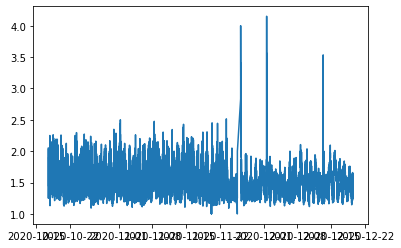

In [8]:
plt.plot(df_test.Timestamps, df_test.Values)
plt.show()

### STL Decomposition

* Note: The trend around the start and end of the time series is extrapolated, otherwise it would be missing.

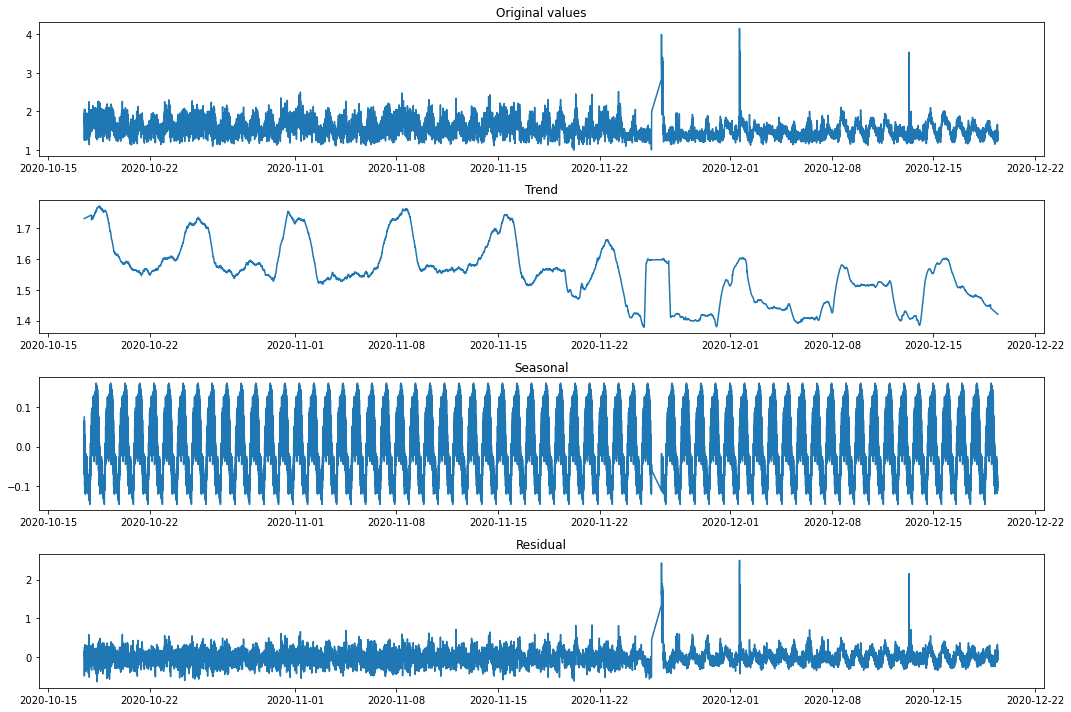

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result = seasonal_decompose(df_test.Values, period=STL_DECOMP_PERIOD, extrapolate_trend='freq')

fig, axs = plt.subplots(4,1, figsize=(15,10), sharex=False)
axs[0].plot(df_test.Timestamps, df_test.Values)
axs[0].set_title('Original values')
axs[1].plot(df_test.Timestamps, decompose_result.trend)
axs[1].set_title('Trend')
axs[2].plot(df_test.Timestamps, decompose_result.seasonal)
axs[2].set_title('Seasonal')
axs[3].plot(df_test.Timestamps, decompose_result.resid)
axs[3].set_title('Residual')
plt.tight_layout()
plt.show()

In [10]:
df_test['Trend_Values'] = decompose_result.trend
df_test['Seasonal_Values'] = decompose_result.seasonal
df_test['Residual_Values'] = decompose_result.resid
df_test.head()

,Timestamps,Values,PostRelease,Trend_Values,Seasonal_Values,Residual_Values
0,2020-10-17 11:40:00+00:00,2.047619,0,1.731693,0.075146,0.240780
1,2020-10-17 11:45:00+00:00,1.617647,0,1.731775,0.064672,-0.178800
2,2020-10-17 11:50:00+00:00,1.250000,0,1.731858,0.002776,-0.484634
3,2020-10-17 11:55:00+00:00,1.613636,0,1.731941,-0.071009,-0.047296
4,2020-10-17 12:00:00+00:00,1.954545,0,1.732023,0.066730,0.155792


### Model fitting for original values and decomposed residual values

In [11]:
model = IsolationForest(
    max_features = 1.0,
    n_estimators = 50,
    max_samples = 'auto',
    contamination = 0.01,
    random_state = STATE or None
)
model.fit(df_test[['Values']])
df_test['Values_Scores'] = model.decision_function(df_test[['Values']])
df_test['Values_Inliers'] = model.predict(df_test[['Values']])

model.fit(df_test[['Residual_Values']])
df_test['Residual_Values_Scores'] = model.decision_function(df_test[['Residual_Values']])
df_test['Residual_Values_Inliers'] = model.predict(df_test[['Residual_Values']])

print(df_test.head())

                 Timestamps    Values  PostRelease  Trend_Values  \
0 2020-10-17 11:40:00+00:00  2.047619            0      1.731693   
1 2020-10-17 11:45:00+00:00  1.617647            0      1.731775   
2 2020-10-17 11:50:00+00:00  1.250000            0      1.731858   
3 2020-10-17 11:55:00+00:00  1.613636            0      1.731941   
4 2020-10-17 12:00:00+00:00  1.954545            0      1.732023   

   Seasonal_Values  Residual_Values  Values_Scores  Values_Inliers  \
0         0.075146         0.240780       0.060248               1   
1         0.064672        -0.178800       0.222699               1   
2         0.002776        -0.484634       0.128317               1   
3        -0.071009        -0.047296       0.219818               1   
4         0.066730         0.155792       0.129485               1   

   Residual_Values_Scores  Residual_Values_Inliers  
0                0.193403                        1  
1                0.223953                        1  
2          

### Cleaning up point anomalies with optional parameters

In [12]:
# Removing anomalies not part of a group at least ANOMALY_NEIGHBOR_LIMIT long
try:
    df_test = util.limit_anomalies(df_test, 'Values_Inliers', -1, 1, ANOMALY_NEIGHBOR_LIMIT)
    df_test = util.limit_anomalies(df_test, 'Residual_Values_Inliers', -1, 1,  ANOMALY_NEIGHBOR_LIMIT)
except NameError:
    pass # Optional ANOMALY_NEIGHBOR_LIMIT undefined, continuing.

Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 potential anomaly
Dropping 1 pot

In [13]:
values_anomaly_counts = df_test.Values_Inliers.value_counts()[-1]
residual_values_anomaly_counts = df_test.Residual_Values_Inliers.value_counts()[-1]
print(f'Anomalous data points from raw values: {values_anomaly_counts} / {len(df_test["Values_Inliers"])}')
print(f'Anomalous data points from decomposed residual values: {residual_values_anomaly_counts} / {len(df_test["Residual_Values_Inliers"])}')

Anomalous data points from raw values: 56 / 17936
Anomalous data points from decomposed residual values: 64 / 17936


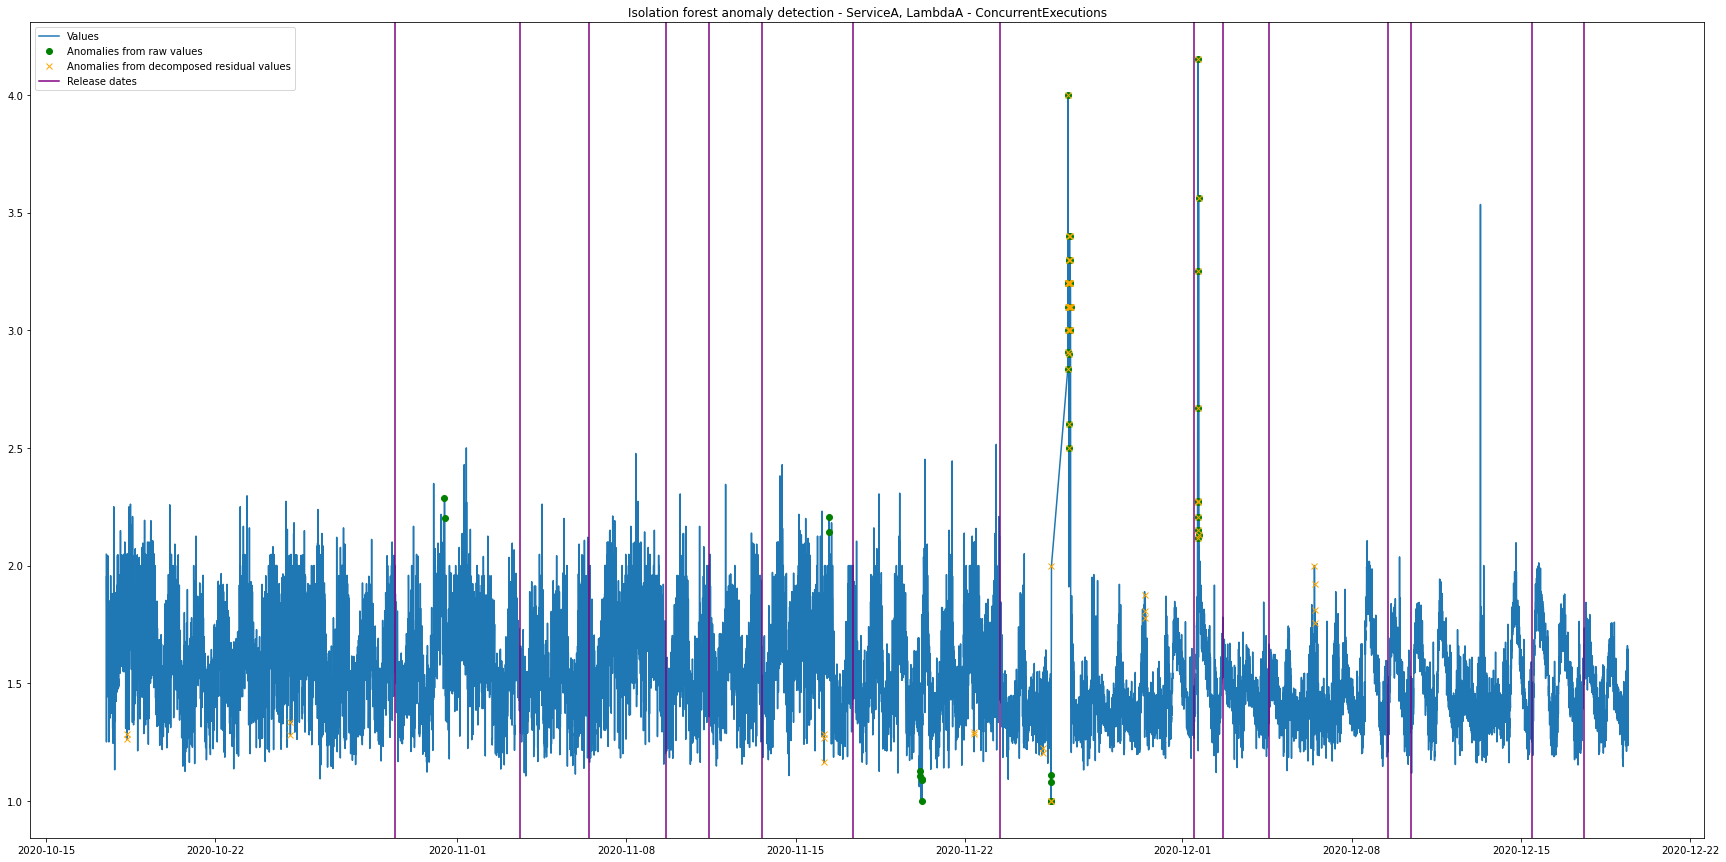

In [14]:
values_anomalies = df_test.loc[df_test.Values_Inliers == -1]
residual_values_anomalies = df_test.loc[df_test.Residual_Values_Inliers == -1]
release_points = df_test.loc[df_test.ReleasePoint == 1]

from matplotlib.pyplot import figure
plt.figure(figsize=(30,15))
plt.plot(df_test.Timestamps, df_test.Values)
plt.plot(values_anomalies.Timestamps, values_anomalies.Values, 'o', color='green')
plt.plot(residual_values_anomalies.Timestamps, residual_values_anomalies.Values, 'x', color='orange')

for release in release_points.Timestamps:
    plt.axvline(release, color='purple')

plt.title(f'Isolation forest anomaly detection - {SERVICE}, {LAMBDA} - {METRIC}')
plt.legend(['Values', 'Anomalies from raw values', 'Anomalies from decomposed residual values', 'Release dates'])


# Output .png & .pdf files
import os

savedir = f'{os.getcwd()}\\output\\{SERVICE}\\{LAMBDA}'
if not os.path.exists(savedir):
    os.makedirs(savedir)
plt.savefig(f'{savedir}\\{METRIC}.pdf')
plt.savefig(f'{savedir}\\{METRIC}.png')


plt.show()

In [15]:
import winsound
winsound.Beep(300, 100)
winsound.Beep(450, 100)